### Global Imports

In [15]:
import os
import datetime
import numpy as np
import tensorflow as tf

from tensorflow.python.keras.preprocessing.image import apply_transform
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

from deepcell.image_generators import MovieDataGenerator

### Get Data

In [16]:
def get_data(file_name, mode='sample', test_size=.1, seed=None):
    """Load data from NPZ file and split into train and test sets
    # Arguments
        file_name: path to NPZ file to load
        mode: if 'sample', will return datapoints for each pixel,
              otherwise, returns the same data that was loaded
        test_size: percent of data to leave as testing holdout
        seed: seed number for random train/test split repeatability
    # Returns
        dict of training data, and a tuple of testing data:
        train_dict, (X_test, y_test)
    """
    training_data = np.load(file_name)
    X = training_data['X']
    y = training_data['y']
    win_x = training_data['win_x']
    win_y = training_data['win_y']
    win_z = None

    class_weights = training_data['class_weights'] if 'class_weights' in training_data else None

    if mode == 'sample' and X.ndim == 4:
        batch = training_data['batch']
        pixels_x = training_data['pixels_x']
        pixels_y = training_data['pixels_y']

        if CHANNELS_FIRST:
            sample_shape = (len(batch), X.shape[1], 2 * win_x + 1, 2 * win_y + 1)
        else:
            sample_shape = (len(batch), 2 * win_x + 1, 2 * win_y + 1, X.shape[3])
        X_sample = np.zeros(sample_shape, dtype=K.floatx())

        for i, (b, px, py) in enumerate(zip(batch, pixels_x, pixels_y)):
            if CHANNELS_FIRST:
                X_sample[i] = X[b, :, px - win_x:px + win_x + 1, py - win_y:py + win_y + 1]
            else:
                X_sample[i] = X[b, px - win_x:px + win_x + 1, py - win_y:py + win_y + 1, :]

        X = X_sample


    # siamese_data mode creates additional channels for tracking data (centroid x, centroid y, etc)
    if mode == 'siamese_data':
        batch_length = X.shape[0]

        if CHANNELS_FIRST:
            X_new = np.zeros((X.shape[0], X.shape[1]+2, X.shape[2], X.shape[3], X.shape[4]))
            x_centroid_weight_dist = np.zeros(X.shape[3], X.shape[4])
            y_centroid_weight_dist = np.zeros(X.shape[3], X.shape[4])
            num_frames = X.shape[2]
        else:
            X_new = np.zeros((X.shape[0], X.shape[1], X.shape[2], X.shape[3], X.shape[4]+2))
            x_centroid_weight_dist = np.zeros((X.shape[2], X.shape[3]))
            y_centroid_weight_dist = np.zeros((X.shape[2], X.shape[3]))
            num_frames = X.shape[1]

        for b in range(batch_length):
            for f in range(num_frames):
                if CHANNELS_FIRST:
                    X_new[b,1,f,:,:] = X[b,0,f,:,:]
                    X_new[b,1,f,:,:], X_new[b,2,f,:,:] = centroid_weighted_distance_transform_2d(y[b,0,f,:,:])
                else:
                    X_new[b,f,:,:,0] = X[b,f,:,:,0]
                    X_new[b,f,:,:,1], X_new[b,f,:,:,2] = centroid_weighted_distance_transform_2d(y[b,f,:,:,0])

        X = X_new
    # End changes for data mode

    elif mode == 'sample' and X.ndim == 5:
        batch = training_data['batch']
        pixels_x = training_data['pixels_x']
        pixels_y = training_data['pixels_y']
        pixels_z = training_data['pixels_z']
        win_z = training_data['win_z']

        if CHANNELS_FIRST:
            sample_shape = (len(batch), X.shape[1], 2 * win_z + 1, 2 * win_x + 1, 2 * win_y + 1)
        else:
            sample_shape = (len(batch), 2 * win_z + 1, 2 * win_x + 1, 2 * win_y + 1, X.shape[4])
        X_sample = np.zeros(sample_shape, dtype=K.floatx())

        for i, (b, px, py, pz) in enumerate(zip(batch, pixels_x, pixels_y, pixels_z)):
            if CHANNELS_FIRST:
                X_sample[i] = X[b, :, pz - win_z:pz + win_z + 1, px - win_x:px + win_x + 1, py - win_y:py + win_y + 1]
            else:
                X_sample[i] = X[b, pz - win_z:pz + win_z + 1, px - win_x:px + win_x + 1, py - win_y:py + win_y + 1, :]

        X = X_sample

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=seed)

    train_dict = {
        'X': X_train,
        'y': y_train,
        'class_weights': class_weights,
        'win_x': win_x,
        'win_y': win_y
    }
    
    val_dict = {
        'X': X_test,
        'y': y_test,
        'class_weights': class_weights,
        'win_x': win_x,
        'win_y': win_y
        
    }

    # siamese_daughters mode is used to import lineage data and associate it with the appropriate batch
    if mode == 'siamese_daughters':
        kid_data = np.load(os.path.splitext(file_name)[0]+'_kids.npz')
        daughters = kid_data['daughters']
        X_train, X_test, y_train, y_test, lineage_train, lineage_test = train_test_split(X, y, daughters, test_size=test_size, random_state=seed)
        train_dict = {
            'X': X_train,
            'y': y_train,
            'daughters': lineage_train,
            'class_weights': class_weights,
            'win_x': win_x,
            'win_y': win_y
        }
        
        val_dict = {
            'X': X_test,
            'y': y_test,
            'daughters': lineage_test,
            'class_weights': class_weights,
            'win_x': win_x,
            'win_y': win_y
        }
        
    # End changes for daughter mode

    if win_z is not None:
        train_dict['win_z'] = win_z
        val_dict['win_z'] = win_z


    return train_dict, val_dict

### Data Generators

In [93]:
from tensorflow.python.keras.preprocessing.image import Iterator
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

from tensorflow.python.keras import backend as K
from sklearn.model_selection import train_test_split
from scipy.stats import special_ortho_group
from skimage.measure import label
from skimage.measure import regionprops
from skimage.transform import resize

class SiameseDataGenerator(ImageDataGenerator):
    def flow(self,
             train_dict,
             crop_dim=32,
             min_track_length=5,
             batch_size=32,
             occupancy_grid_size = 20,
             occupancy_window = 25,
             shuffle=True,
             output_mode='disc',
             seed=None,
             data_format=None,
             save_to_dir=None,
             save_prefix='',
             save_format='png'):
        return SiameseIterator(
            train_dict,
            self,
            crop_dim=crop_dim,
            min_track_length=min_track_length,
            batch_size=batch_size,
            occupancy_grid_size = occupancy_grid_size,
            occupancy_window = occupancy_window,
            shuffle=shuffle,
            seed=seed,
            data_format=data_format,
            save_to_dir=save_to_dir,
            save_prefix=save_prefix,
            save_format=save_format)


class SiameseIterator(Iterator):
    def __init__(self,
                 train_dict,
                 image_data_generator,
                 crop_dim=14,
                 min_track_length=5,
                 batch_size=32,
                 occupancy_grid_size = 10,
                 occupancy_window = 100,
                 shuffle=False,
                 seed=None,
                 squeeze=False,
                 data_format=None,
                 save_to_dir=None,
                 save_prefix='',
                 save_format='png'):
        if data_format is None:
            data_format = K.image_data_format()

        if data_format == 'channels_first':
            self.channel_axis = 1
            self.row_axis = 3
            self.col_axis = 4
            self.time_axis = 2
        if data_format == 'channels_last':
            self.channel_axis = 4
            self.row_axis = 2
            self.col_axis = 3
            self.time_axis = 1
        self.x = np.asarray(train_dict['X'], dtype=K.floatx())
        self.y = np.array(train_dict['y'], dtype='int32')

        if self.x.ndim != 5:
            raise ValueError('Input data in `SiameseIterator` '
                             'should have rank 5. You passed an array '
                             'with shape', self.x.shape)

        self.crop_dim = crop_dim
        self.min_track_length = min_track_length
        self.occupancy_grid_size = np.int(occupancy_grid_size)
        self.occupancy_window = np.int(occupancy_window)
        self.image_data_generator = image_data_generator
        self.squeeze = squeeze
        self.data_format = data_format
        self.save_to_dir = save_to_dir
        self.save_prefix = save_prefix
        self.save_format = save_format

        if 'daughters' in train_dict:
            self.daughters = train_dict['daughters']
        else:
            self.daughters = None

        self._remove_bad_images()
        self._create_track_ids()
        self._create_appearances()

        super(SiameseIterator, self).__init__(
            len(self.track_ids), batch_size, shuffle, seed)

    def _remove_bad_images(self):
        """
        This function goes through all of the batches of images and removes the 
        images that only have one cell.
        """
        good_batches = []
        number_of_batches = self.x.shape[0]
        for batch in range(number_of_batches):
            y = self.y[batch]
            unique_ids = np.unique(y.flatten())
            if len(unique_ids) > 2: # You should have at least 3 id's - 2 cells and 1 background
                good_batches.append(batch)

        X_new_shape = tuple([len(good_batches)] + list(self.x.shape[1:]))
        y_new_shape = tuple([len(good_batches)] + list(self.y.shape[1:]))

        X_new = np.zeros(X_new_shape, dtype = K.floatx())
        y_new = np.zeros(y_new_shape, dtype = np.int32)

        counter = 0
        for k, batch in enumerate(good_batches):
            X_new[k] = self.x[batch]
            y_new[k] = self.y[batch]

        self.x = X_new
        self.y = y_new

        return None

    def _create_track_ids(self):
        """
        This function builds the track id's. It returns a dictionary that
        contains the batch number and label number of each each track.
        Creates unique cell IDs, as cell labels are NOT unique across batches.
        """
        track_counter = 0
        track_ids = {}
        for batch in range(self.y.shape[0]):
            y_batch = self.y[batch]
            num_cells = np.amax(y_batch)
            for cell in range(1, num_cells + 1):
                # count number of pixels cell occupies in each frame
                y_true = np.sum(y_batch == cell, axis=(self.row_axis - 1, self.col_axis - 1))
                # get indices of frames where cell is present
                y_index = np.where(y_true > 0)[0]
                if y_index.size > 3: #self.min_track_length+1:  # if cell is present at all
                    if self.daughters is not None:
                        # Only include daughters if there are enough frames in their tracks
                        daughter_ids = self.daughters[batch][cell]
                        if len(daughter_ids) > 0:
                            daughter_track_lengths = []
                            for did in daughter_ids:
                                # Screen daughter tracks to make sure they are long enough
                                # Length currently set to 0
                                d_true = np.sum(y_batch == did, axis=(self.row_axis - 1, self.col_axis - 1))
                                d_track_length = len(np.where(d_true>0)[0])
                                daughter_track_lengths.append(d_track_length > 3)
                            keep_daughters = all(daughter_track_lengths)
                            daughters = daughter_ids if keep_daughters else []
                        else:
                            daughters = []
                    else:
                        daughters = []
                            
                    track_ids[track_counter] = {
                        'batch': batch,
                        'label': cell,
                        'frames': y_index,
                        'daughters': daughters  
                    }
                                
                    track_counter += 1

                else:
                    y_batch[y_batch == cell] = 0
            self.y[batch] = y_batch
                    
        # Add a field to the track_ids dict that locates all of the different cells
        # in each frame
        for track in track_ids.keys():
            track_ids[track]['different'] = {}
            batch = track_ids[track]['batch']
            label = track_ids[track]['label']
            for frame in track_ids[track]['frames']:
                y_unique = np.unique(self.y[batch][frame])
                y_unique = np.delete(y_unique, np.where(y_unique == 0))
                y_unique = np.delete(y_unique, np.where(y_unique == label))
                track_ids[track]['different'][frame] = y_unique  
                        
        # We will need to look up the track_ids of cells if we know their batch and label. We will 
        # create a dictionary that stores this information
        reverse_track_ids = {}
        for batch in range(self.y.shape[0]):
            reverse_track_ids[batch] = {}
        for track in track_ids.keys():
            batch = track_ids[track]['batch']
            label = track_ids[track]['label']
            reverse_track_ids[batch][label] = track
            
        # Save dictionaries
        self.track_ids = track_ids
        self.reverse_track_ids = reverse_track_ids
        
        # Identify which tracks have divisions
        self.tracks_with_divisions = []
        for track in self.track_ids.keys():
            if len(self.track_ids[track]['daughters']) > 0:
                self.tracks_with_divisions.append(track)
                
        # Identify which tracks are daughters
        self.tracks_that_are_daughters = []
        for track in track_ids.keys():
            if len(track_ids[track]['daughters']) > 0:
                for did in track_ids[track]['daughters']:
                    batch = track_ids[track]['batch']
                    daughter_track = self.reverse_track_ids[batch][did]
                    self.tracks_that_are_daughters.append(daughter_track)
                
        return None

    def _get_appearances(self, X, y, frames, labels):
        channel_axis = self.channel_axis - 1
        if self.data_format == 'channels_first':
            appearance_shape = (X.shape[channel_axis],
                                len(frames),
                                self.crop_dim,
                                self.crop_dim)
        else:
            appearance_shape = (len(frames),
                                self.crop_dim,
                                self.crop_dim,
                                X.shape[channel_axis])

        occupancy_grid_shape = (len(frames), 2*self.occupancy_grid_size+1, 2*self.occupancy_grid_size+1,1)
        
        # Initialize storage for appearances and centroids
        appearances = np.zeros(appearance_shape, dtype=K.floatx())
        centroids = []
        occupancy_grids = np.zeros(occupancy_grid_shape, dtype = K.floatx())

        for counter, (frame, cell_label) in enumerate(zip(frames, labels)):
            # Get the bounding box
            X_frame = X[frame] if self.data_format == 'channels_last' else X[:, frame]
            y_frame = y[frame] if self.data_format == 'channels_last' else y[:, frame]
            props = regionprops(np.int32(y_frame == cell_label))
            minr, minc, maxr, maxc = props[0].bbox
            centroids.append(props[0].centroid)

            # Extract images from bounding boxes
            if self.data_format == 'channels_first':
                appearance = np.copy(X[:, frame, minr:maxr, minc:maxc])
                resize_shape = (X.shape[channel_axis], self.crop_dim, self.crop_dim)
            else:
                appearance = np.copy(X[frame, minr:maxr, minc:maxc, :])
                resize_shape = (self.crop_dim, self.crop_dim, X.shape[channel_axis])

            # Resize images from bounding box
            max_value = np.amax([np.amax(appearance), np.absolute(np.amin(appearance))])
            appearance /= max_value
            appearance = resize(appearance, resize_shape)
            appearance *= max_value
            if self.data_format == 'channels_first':
                appearances[:, counter] = appearance
            else:
                appearances[counter] = appearance
                
            # Get occupancy grid
            occupancy_grid = np.zeros((2*self.occupancy_grid_size+1, 2*self.occupancy_grid_size+1,1), 
                                      dtype=K.floatx())
            X_padded = np.pad(X_frame, ((self.occupancy_window, self.occupancy_window), 
                                        (self.occupancy_window, self.occupancy_window),
                                        (0,0)), mode='constant', constant_values=0)
            y_padded = np.pad(y_frame, ((self.occupancy_window, self.occupancy_window), 
                                        (self.occupancy_window, self.occupancy_window),
                                        (0,0)), mode='constant', constant_values=0)
            props = regionprops(np.int32(y_padded == cell_label))
            center_x, center_y = props[0].centroid
            center_x, center_y = np.int(center_x), np.int(center_y)
            X_reduced = X_padded[center_x-self.occupancy_window:center_x+self.occupancy_window,
                                 center_y-self.occupancy_window:center_y+self.occupancy_window,:]
            y_reduced = y_padded[center_x-self.occupancy_window:center_x+self.occupancy_window,
                                 center_y-self.occupancy_window:center_y+self.occupancy_window,:]
            
            # Resize X_reduced in case it is used instead of the occupancy grid method
            resize_shape = (2*self.occupancy_grid_size+1, 2*self.occupancy_grid_size+1, X.shape[channel_axis])

            # Resize images from bounding box
            max_value = np.amax([np.amax(X_reduced), np.absolute(np.amin(X_reduced))])
            X_reduced /= max_value
            X_reduced = resize(X_reduced, resize_shape)
            X_reduced *= max_value
            
            # Fill up the occupancy grid
            center_x, center_y = self.occupancy_window, self.occupancy_window
            props = regionprops(np.int32(y_reduced))
            for prop in props:
                centroid_x, centroid_y = prop.centroid
                dist_x, dist_y = np.float(centroid_x - center_x), np.float(centroid_y - center_y)
                dist_x *= self.occupancy_grid_size/self.occupancy_window
                dist_y *= self.occupancy_grid_size/self.occupancy_window
                
                loc_x = np.int(np.floor(self.occupancy_grid_size + dist_x))
                loc_y = np.int(np.floor(self.occupancy_grid_size + dist_y))
                
                mark_grid = (loc_x >= 0) and (loc_x < occupancy_grid.shape[0]) and (loc_y >=0) and (loc_y < occupancy_grid.shape[1]) 
                
                if mark_grid:
                    occupancy_grid[loc_x, loc_y,0] = 1
                    
            occupancy_grids[counter,:,:,:] = 0 #X_reduced #occupancy_grid
            
        return [appearances, centroids, occupancy_grids]

    def _create_appearances(self):
        """
        This function gets the appearances of every cell, crops them out, resizes them, 
        and stores them in an matrix. Pre-fetching the appearances should significantly 
        speed up the generator. It also gets the centroids and occupancy grids
        """
        number_of_tracks = len(self.track_ids.keys())

        # Initialize the array for the appearances and centroids
        if self.data_format =='channels_first':
            all_appearances_shape = (number_of_tracks, self.x.shape[self.channel_axis], self.x.shape[self.time_axis], self.crop_dim, self.crop_dim)
        if self.data_format == 'channels_last':
            all_appearances_shape = (number_of_tracks, self.x.shape[self.time_axis], self.crop_dim, self.crop_dim, self.x.shape[self.channel_axis])
        all_appearances = np.zeros(all_appearances_shape, dtype = K.floatx())

        all_centroids_shape = (number_of_tracks, self.x.shape[self.time_axis],2)
        all_centroids = np.zeros(all_centroids_shape, dtype = K.floatx())
        
        all_occupancy_grids_shape = (number_of_tracks, self.x.shape[self.time_axis], 
                                     2*self.occupancy_grid_size+1, 2*self.occupancy_grid_size+1, 1)
        all_occupancy_grids = np.zeros(all_occupancy_grids_shape, dtype = K.floatx())

        for track in self.track_ids.keys():
            batch = self.track_ids[track]['batch']
            label = self.track_ids[track]['label']
            frames = self.track_ids[track]['frames']

            # Make an array of labels that the same length as the frames array
            labels = [label] * len(frames)
            X = self.x[batch]
            y = self.y[batch]

            app = self._get_appearances(X, y, frames, labels)
            appearance = app[0]
            centroid = app[1]
            occupancy_grid = app[2]

            if self.data_format == 'channels_first':
                all_appearances[track,:,np.array(frames),:,:] = appearance 
            if self.data_format == 'channels_last':
                all_appearances[track,np.array(frames),:,:,:] = appearance

            all_centroids[track,np.array(frames),:] = centroid
            
            all_occupancy_grids[track, np.array(frames),:,:] = occupancy_grid
            
        self.all_appearances = all_appearances
        self.all_centroids = all_centroids
        self.all_occupancy_grids = all_occupancy_grids
        
        return None

    def _fetch_appearances(self, track, frames):
        """
        This function gets the appearances after they have been 
        cropped out of the image
        """
        # TO DO: Check to make sure the frames are acceptable

        if self.data_format == 'channels_first':
            appearances = self.all_appearances[track,:,np.array(frames),:,:]
        if self.data_format == 'channels_last':
            appearances = self.all_appearances[track,np.array(frames),:,:,:]
        return appearances

    def _fetch_centroids(self, track, frames):
        """
        This function gets the centroids after they have been
        extracted and stored
        """
        # TO DO: Check to make sure the frames are acceptable
        
        centroids = self.all_centroids[track,np.array(frames),:]
        return centroids
    
    def _fetch_occupancy_grids(self, track, frames):
        """
        This function gets the occupancy grids after they have been
        extracted and stored
        """
        # TO DO: Check to make sure the frames are acceptable
        
        occupancy_grids = self.all_occupancy_grids[track,np.array(frames),:,:,:]
        return occupancy_grids

    def _fetch_frames(self, track, output_mode='disc', division=False):
        """
        This function fetches a random list of frames for a given track.
        If the division flag is true, then the list of frames ends at the cell's
        last appearance if the division flag is true.
        """
        track_id = self.track_ids[track]
        batch = track_id['batch']
        tracked_frames = list(track_id['frames'])

        # We need to have at least one future frame to pick from, so if 
        # the last frame of the movie is a tracked frame, remove it
        last_frame = self.x.shape[self.time_axis] - 1
        if last_frame in tracked_frames:
            tracked_frames.remove(last_frame)

        # Get the indices of the tracked_frames list - sometimes frames
        # are skipped
        tracked_frames_index = np.arange(len(tracked_frames))
        
        # Check if there are enough frames
        enough_frames = len(tracked_frames_index) > self.min_track_length + 1

        # We need to exclude the last frame so that we will always be able to make a comparison
        acceptable_indices = tracked_frames_index[self.min_track_length-1:-1] if enough_frames else tracked_frames_index[:-1]

        # Take the last frame if there is a division, otherwise randomly pick a frame
        index = -1 if division else np.random.choice(acceptable_indices) 

        # Select the frames. If there aren't enough frames, repeat the first frame
        # the necessary number of times
        if enough_frames:
            frames = tracked_frames[index+1-self.min_track_length:index+1]
        else:
            frames_temp = tracked_frames[0:index+1]
            missing_frames = self.min_track_length - len(frames_temp)
            frames = [tracked_frames[0]] * missing_frames + frames_temp

        return frames

    def _get_batches_of_transformed_samples(self, index_array):
        # Initialize batch_x_1, batch_x_2, and batch_y, as well as cell distance data
        # DVV Notes - I'm changing how this works. We will now only compare cells in neighboring
        # frames. I am also modifying it so it will select a sequence of cells/distances for x1
        # and 1 cell/distance for x2

        if self.data_format == 'channels_first':
            x1_shape = (len(index_array), self.x.shape[self.channel_axis], self.min_track_length, self.crop_dim, self.crop_dim)
            x2_shape = (len(index_array), self.x.shape[self.channel_axis], self.crop_dim, self.crop_dim)
        else:
            x1_shape = (len(index_array), self.min_track_length, self.crop_dim, self.crop_dim, self.x.shape[self.channel_axis])
            x2_shape = (len(index_array), 1, self.crop_dim, self.crop_dim, self.x.shape[self.channel_axis])
        distance_shape_1 = (len(index_array), self.min_track_length, 2)
        distance_shape_2 = (len(index_array), 1, 2)
        
        occupancy_grid_shape_1 = (len(index_array), self.min_track_length, 
                                  2*self.occupancy_grid_size+1, 2*self.occupancy_grid_size+1, 1)
        occupancy_grid_shape_2 = (len(index_array), 1, 2*self.occupancy_grid_size+1, 
                                  2*self.occupancy_grid_size+1, 1)
        
        y_shape = (len(index_array), 3)

        batch_x_1 = np.zeros(x1_shape, dtype=K.floatx())
        batch_x_2 = np.zeros(x2_shape, dtype=K.floatx())
        batch_distance_1 = np.zeros(distance_shape_1, dtype=K.floatx())
        batch_distance_2 = np.zeros(distance_shape_2, dtype=K.floatx())
        batch_occupancy_grid_1 = np.zeros(occupancy_grid_shape_1, dtype=K.floatx())
        batch_occupancy_grid_2 = np.zeros(occupancy_grid_shape_2, dtype=K.floatx())
        batch_y = np.zeros(y_shape, dtype=np.int32)

        for i, j in enumerate(index_array):                        
            # Identify which tracks are going to be selected
            track_id = self.track_ids[j]
            batch = track_id['batch']
            label_1 = track_id['label']  
            
            X = self.x[batch]
            y = self.y[batch]

            # Choose comparison cell
            # Determine what class the track will be - different (0), same (1), division (2)
            # is_same_cell = np.random.random_integers(0, 1)
            division = False
            type_cell = np.random.choice([0,1,2], p = [1./3., 1./3., 1./3.])

            # Dealing with edge cases

            # If class is division, check if the first cell divides. If not, change tracks
            if type_cell == 2:
                if len(track_id['daughters']) == 0:
                    # No divisions so randomly choose a different track that is
                    # guaranteed to have a division
                    new_j = np.random.choice(self.tracks_with_divisions)
                    j = new_j
                    track_id = self.track_ids[j]
                    batch = track_id['batch']
                    label_1 = track_id['label']
                    X = self.x[batch]
                    y = self.y[batch]
                    division == True
                else:
                    division == True
                    
            # Get the frames for cell 1 and frames/label for cell 2
            frames_1 = self._fetch_frames(j, division=division)
            
            # For frame_2, choose the next frame cell 1 appears in 
            last_frame_1 = np.amax(frames_1)            
            frame_2 = np.amin( [x for x in track_id['frames'] if x > last_frame_1] )
            frames_2 = [frame_2]

            different_cells = track_id['different'][frame_2]
                    
            if type_cell == 0:
                # If there are no different cells in the subsequent frame, we must choose 
                # the same cell
                if len(different_cells) == 0:
                    type_cell = 1
                else:
                    label_2 = np.random.choice(different_cells)

            if type_cell == 1:
                # If there is only 1 cell in frame_2, we can only choose the class to be same
                label_2 = label_1
                        
            if type_cell == 2:
                # There should always be 2 daughters but not always a valid label
                label_2 = np.int(np.random.choice(track_id['daughters'])) 
                daughter_track = self.reverse_track_ids[batch][label_2]
                frame_2 = np.amin(self.track_ids[daughter_track]['frames'])
                frames_2 = [frame_2]

            track_1 = j
            track_2 = self.reverse_track_ids[batch][label_2]

            # Get appearances, centroid, and occupancy grid data
            appearance_1 = self._fetch_appearances(track_1, frames_1)
            appearance_2 = self._fetch_appearances(track_2, frames_2)
            centroid_1 = self._fetch_centroids(track_1, frames_1)
            centroid_2 = self._fetch_centroids(track_2, frames_2)
            occupancy_grid_1 = self._fetch_occupancy_grids(track_1, frames_1)
            occupancy_grid_2 = self._fetch_occupancy_grids(track_2, frames_2)
            
            # Apply random transforms
            new_appearance_1 = np.zeros(appearance_1.shape, dtype = K.floatx())
            new_appearance_2 = np.zeros(appearance_2.shape, dtype = K.floatx())

            for frame in range(appearance_1.shape[self.time_axis-1]):
                if self.data_format == 'channels_first':
                    app_temp = self.image_data_generator.random_transform(appearance_1[:,frame,:,:])
                    app_temp = self.image_data_generator.standardize(app_temp)
                    new_appearance_1[:,frame,:,:] = app_temp                        

                if self.data_format == 'channels_last':
                    app_temp = self.image_data_generator.random_transform(appearance_1[frame])
                    app_temp = self.image_data_generator.standardize(app_temp)
                    new_appearance_1[frame] = app_temp

            if self.data_format == 'channels_first':
                app_temp = self.image_data_generator.random_transform(appearance_2[:,0,:,:])
                app_temp = self.image_data_generator.standardize(app_temp)
                new_appearance_2[:,0,:,:] = app_temp   
                
            if self.data_format == 'channels_last':
                app_temp = self.image_data_generator.random_transform(appearance_2[0])
                app_temp = self.image_data_generator.standardize(app_temp)
                new_appearance_2[0] = app_temp

            # Compute distances between centroids
            centroids = np.concatenate([centroid_1, centroid_2], axis=0)
            distance = np.diff(centroids, axis=0)
            zero_pad = np.zeros((1,2), dtype = K.floatx())
            distance = np.concatenate([zero_pad, distance], axis=0)
            
            # Randomly rotate and expand all the distances
            theta = 2*np.pi*np.random.random()
            c, s = np.cos(theta), np.sin(theta)
            R = np.array(((c,-s), (s, c)))
            for k in range(distance.shape[0]):
                theta = 2*np.pi*np.random.random() + np.pi/10* np.random.uniform(low=-1, high=1)
                c, s = np.cos(theta), np.sin(theta)
                R = np.array(((c,-s), (s, c)))
                dilation = np.random.uniform(low=0.8, high=1.2)
                distance[k] = np.matmul(R, distance[k]*dilation)
                
            # Randomly transform the occupancy maps
            occupancy_generator = MovieDataGenerator(rotation_range=180, 
                                                    horizontal_flip=True,
                                                    vertical_flip=True)
            
            occupancy_grids = np.concatenate([occupancy_grid_1, occupancy_grid_2], axis=0)
            occupancy_grids = occupancy_generator.random_transform(occupancy_grids)
            
#             for frame in range(occupancy_grids.shape[self.time_axis-1]):
#                 og_temp = occupancy_grids[frame]
#                 og_temp = self.image_data_generator.random_transform(og_temp)
#                 occupancy_grids[frame] = og_temp
            
            occupancy_grid_1 = occupancy_grids[0:-1,:,:,:]
            occupancy_grid_2 = occupancy_grids[[-1],:,:,:]
                
            # Save images and distances to the batch arrays
            batch_x_1[i] = appearance_1
            batch_x_2[i] = appearance_2
            batch_distance_1[i] = distance[0:-1,:]
            batch_distance_2[i,0,:] = distance[-1,:]
            batch_occupancy_grid_1[i] = occupancy_grid_1
            batch_occupancy_grid_2[i,0,:,:,:] = occupancy_grid_2
            batch_y[i, type_cell] = 1
   
        # Remove singleton dimensions (if min_track_length is 1)
        if self.squeeze:
            batch_x_1 = np.squeeze(batch_x_1, axis=self.time_axis)
            batch_x_2 = np.squeeze(batch_x_2, axis=self.time_axis)
            batch_distance_1 = np.squeeze(batch_distance_1, axis=1)
            batch_distance_2 = np.squeeze(batch_distance_2, axis=1)
            batch_occupancy_grid_1 = np.squeeze(batch_occupancy_grid_1, axis=1)
            batch_occupancy_grid_2 = np.squeeze(batch_occupancy_grid_2, axis=1)
        return [batch_x_1, batch_x_2, batch_distance_1, batch_distance_2, batch_occupancy_grid_1, batch_occupancy_grid_2], batch_y

    def next(self):
        """For python 2.x.
        # Returns the next batch.
        """
        # Keeps under lock only the mechanism which advances
        # the indexing of each batch.
        with self.lock:
            index_array = next(self.index_generator)
        # The transformation of images is not under thread lock
        # so it can be done in parallel
        return self._get_batches_of_transformed_samples(index_array)


### Testing the Data Generator

In [4]:
train_dict, val_dict = get_data('/data/npz_data/cells/HeLa/S3/movie/nuclear_movie_hela0-3_same.npz',
                                        mode='siamese_daughters')

print('X_train shape:', train_dict['X'].shape)

image_data_generator = SiameseDataGenerator(
        rotation_range=180,  # randomly rotate images by 0 to rotation_range degrees
        shear_range=0, # randomly shear images in the range (radians , -shear_range to shear_range)
        horizontal_flip=0,  # randomly flip images
        vertical_flip=0) 

test_iterator = SiameseIterator(train_dict, image_data_generator, occupancy_window=150, occupancy_grid_size=40, crop_dim=32, min_track_length=5)

X_train shape: (86, 40, 216, 256, 1)


/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


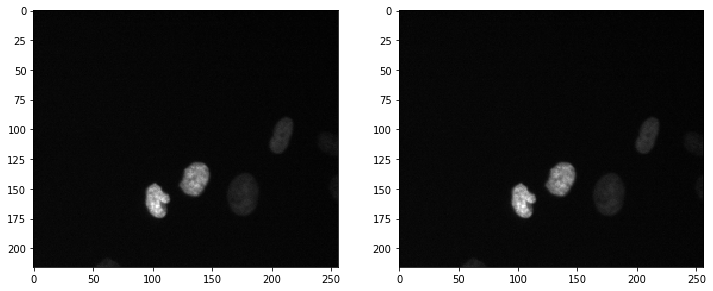

In [5]:
import matplotlib.pyplot as plt
from skimage.io import imshow

# Compare 2 images
img_1 = train_dict['X'][0,1,:,:,0]
img_2 = train_dict['X'][0,1,:,:,0]

fig, ax = plt.subplots(1, 2, figsize=(12,12))
ax[0].imshow(img_1, interpolation='none', cmap='gray')
ax[1].imshow(img_2, interpolation='none', cmap='gray')
plt.show()

In [6]:
(lst, y) = test_iterator.next()
print(test_iterator.tracks_with_divisions)

[3, 13, 23, 28, 36, 39, 53, 63, 69, 88, 118, 142, 193, 212, 239, 244, 257, 260, 265, 267, 278, 311, 329, 353, 356, 419, 464, 492, 501, 523, 537, 541, 585, 613, 652, 655, 660, 663, 684, 692, 697, 721]


In [7]:
print(lst[0].shape)
print(lst[1].shape)
print(lst[2].shape)
print(lst[3].shape)
print(lst[4].shape)
print(lst[5].shape)
print(len(test_iterator.tracks_with_divisions))
print(test_iterator.tracks_with_divisions)

(32, 5, 32, 32, 1)
(32, 1, 32, 32, 1)
(32, 5, 2)
(32, 1, 2)
(32, 5, 81, 81, 1)
(32, 1, 81, 81, 1)
42
[3, 13, 23, 28, 36, 39, 53, 63, 69, 88, 118, 142, 193, 212, 239, 244, 257, 260, 265, 267, 278, 311, 329, 353, 356, 419, 464, 492, 501, 523, 537, 541, 585, 613, 652, 655, 660, 663, 684, 692, 697, 721]


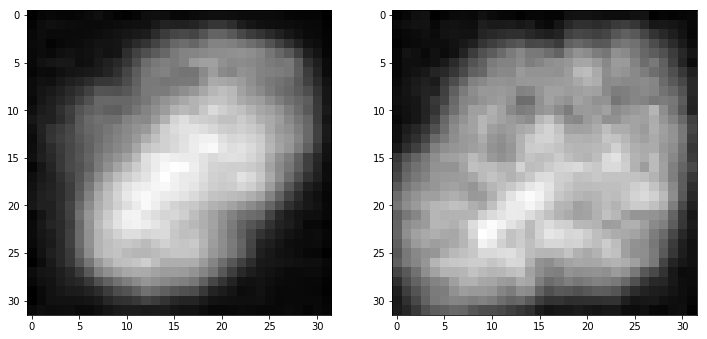

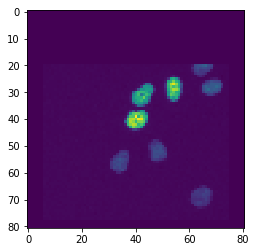

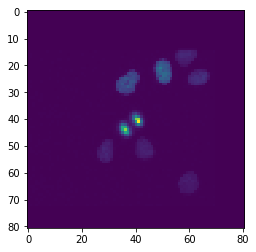

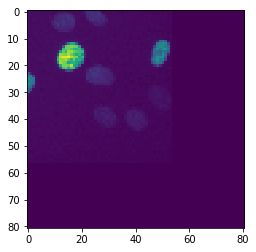

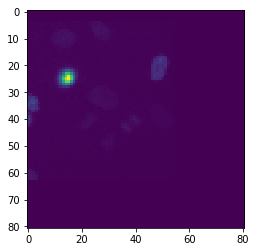

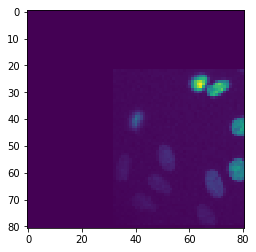

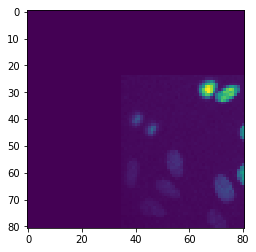

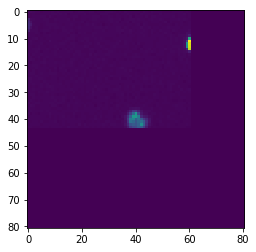

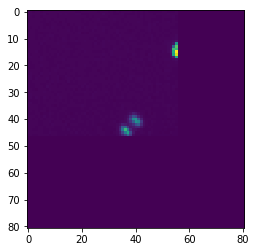

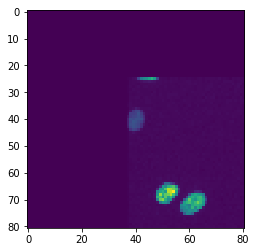

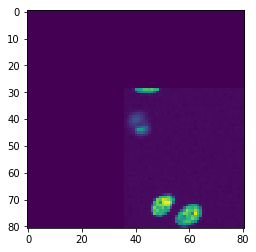

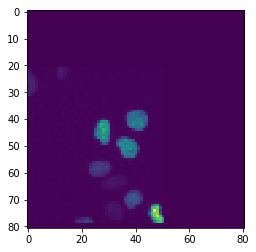

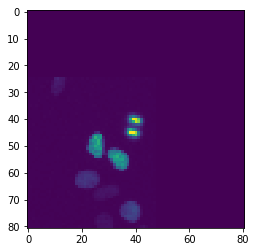

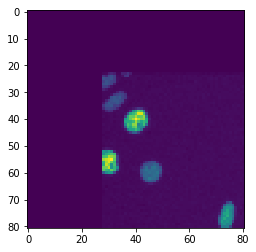

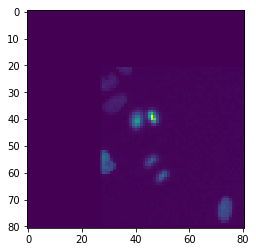

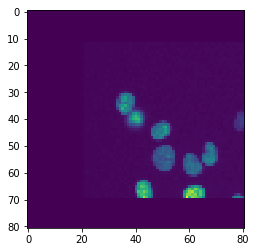

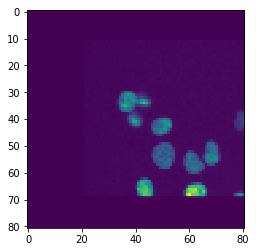

In [8]:
img_1 = lst[0][5,0,:,:,0]
img_2 = lst[1][5,0,:,:,0]
fig, ax = plt.subplots(1, 2, figsize=(12,12))
ax[0].imshow(img_1, interpolation='none', cmap='gray')
ax[1].imshow(img_2, interpolation='none', cmap='gray')
plt.show()
for i in range(32):
    if y[i,2]==1:
        plt.imshow(lst[4][i,-1,:,:,0])
        plt.show()
        plt.imshow(lst[5][i,0,:,:,0])
        plt.show()

[[ 0.          0.        ]
 [-0.8310171   0.98526084]
 [ 0.9304902  -0.20384859]
 [ 0.6716493   0.3931729 ]
 [ 0.82668006 -0.5980563 ]]
0.0
(81, 81, 1)
(81, 81, 1)
(81, 81, 1)
(81, 81, 1)
(81, 81, 1)


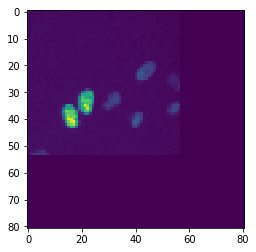

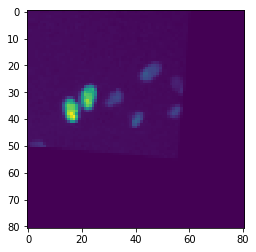

In [9]:
# Print Centroid Data
print(lst[2][3,:])
plt.imshow(lst[4][18,4,:,:,0])
print(np.round(lst[4][0,4,10,10,0], decimals=2))

img = lst[4][5,:,:,:,:]
img_old = lst[4][5,:,:,:,:]

img_new = np.zeros(img.shape)
datagen = ImageDataGenerator(rotation_range=30)
for frame in range(img.shape[0]):
    img_frame = img[frame]
    print(img_frame.shape)
    img_new[frame] = datagen.random_transform(img_frame)

plt.imshow(img_old[0,:,:,0])
plt.show()
plt.imshow(img_new[0,:,:,0])
plt.show()


In [10]:
# Check the labels
print(y)

[[1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [0 0 1]
 [0 0 1]
 [1 0 0]
 [0 0 1]
 [0 0 1]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [0 0 1]]


### Model Zoo

In [11]:
from __future__ import absolute_import
from __future__ import print_function
from __future__ import division

import tensorflow as tf
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.activations import softmax
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Conv2D, Conv3D, ConvLSTM2D, LSTM
from tensorflow.python.keras.layers import Add, Input, Concatenate, Lambda, InputLayer, Layer
from tensorflow.python.keras.layers import MaxPool2D, MaxPool3D, AvgPool2D, UpSampling2D
from tensorflow.python.keras.layers import Flatten, Dense, Dropout, Reshape, TimeDistributed
from tensorflow.python.keras.layers import Activation, Softmax
from tensorflow.python.keras.layers import BatchNormalization
from tensorflow.python.keras.regularizers import l2
from tensorflow.python.framework import tensor_shape

from deepcell.layers import Resize
from deepcell.layers import DilatedMaxPool2D, DilatedMaxPool3D
from deepcell.layers import TensorProd2D, TensorProd3D
from deepcell.layers import Location, Location3D
from deepcell.layers import ImageNormalization2D, ImageNormalization3D

class Location(Layer):
    def __init__(self, data_format=None, **kwargs):
        super(Location, self).__init__(**kwargs)
        if data_format is None:
            self.data_format = K.image_data_format()
        else:
            self.data_format = data_format

    def compute_output_shape(self, input_shape):
        input_shape = tensor_shape.TensorShape(input_shape).as_list()
        if self.data_format == 'channels_first':
            output_shape = (input_shape[0], 2 + input_shape[1], input_shape[2], input_shape[3])
        else:
            output_shape = (input_shape[0], input_shape[1], input_shape[2], 2 + input_shape[-1])
        return tensor_shape.TensorShape(output_shape)

    def call(self, inputs):
        
        input_shape = inputs.get_shape().as_list()
        if self.data_format == 'channels_last':
            x = tf.range(0, input_shape[1], dtype=K.floatx())
            y = tf.range(0, input_shape[2], dtype=K.floatx())

        else:
            x = tf.range(0, input_shape[2], dtype=K.floatx())
            y = tf.range(0, input_shape[3], dtype=K.floatx())

        x = tf.divide(x, tf.reduce_max(x))
        y = tf.divide(y, tf.reduce_max(y))

        loc_x, loc_y = tf.meshgrid(y, x)

        if self.data_format == 'channels_last':
            loc = tf.stack([loc_x, loc_y], axis=-1)
        else:
            loc = tf.stack([loc_x, loc_y], axis=0)

        location = tf.expand_dims(loc, 0)
        location = tf.tile(location, [tf.shape(inputs)[0], 1, 1, 1])
               
        if self.data_format == 'channels_last':
                output = tf.concat([inputs, location], axis = -1)
        else:
            output = tf.concat([inputs, location], axis = 1)

        return output

    def get_config(self):
        config = {
            'data_format': self.data_format
        }
        base_config = super(Location, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [12]:

def siamese_model(input_shape=None, track_length=1, occupancy_grid_size=20, reg=1e-5, init='he_normal', softmax=True, norm_method='std', filter_size=61):

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1

    if K.image_data_format() == 'channels_first':
        new_input_shape = tuple([input_shape[0]] + [None] + list(input_shape[1:]))
    else:
        new_input_shape = tuple([None] + list(input_shape))
        
    input_shape = new_input_shape
        
    # Define the input shape for the images
    input_1 = Input(shape=input_shape)
    input_2 = Input(shape=input_shape)
    
    # Define the input shape for the other data (centroids, etc)
    input_3 = Input(shape=(None, 2))
    input_4 = Input(shape=(None, 2))
    
    input_5 = Input(shape=(None, 2*occupancy_grid_size+1, 2*occupancy_grid_size+1, 1))
    input_6 = Input(shape=(None, 2*occupancy_grid_size+1, 2*occupancy_grid_size+1, 1))

    # Feature extractor for images
    N_layers = np.int(np.floor(np.log2(in_shape[0])))
    feature_extractor = Sequential()
    feature_extractor.add(InputLayer(input_shape=input_shape))
    for layer in range(N_layers):
        feature_extractor.add(Conv3D(64, (1, 3, 3), kernel_initializer=init, padding='same', 
                                     kernel_regularizer=l2(reg)))
        feature_extractor.add(BatchNormalization(axis=channel_axis))
        feature_extractor.add(Activation('relu'))
        feature_extractor.add(MaxPool3D(pool_size=(1, 2, 2)))

    feature_extractor.add(Reshape(tuple([-1, 64])))
    
    # Feature extractor for occupancy grids
    N_layers_og = np.int(np.floor(np.log2(2*occupancy_grid_size+1)))
    feature_extractor_occupancy_grid = Sequential()
    feature_extractor_occupancy_grid.add(InputLayer(input_shape=(None, 2*occupancy_grid_size+1, 2*occupancy_grid_size+1, 1)))   
#     feature_extractor_occupancy_grid.add(TimeDistributed(Location()))
    
    for layer in range(N_layers_og):
        feature_extractor_occupancy_grid.add(Conv3D(64, (1, 3, 3), kernel_initializer=init, padding='same', 
                                                    kernel_regularizer=l2(reg)))
        feature_extractor_occupancy_grid.add(BatchNormalization(axis=channel_axis))
        feature_extractor_occupancy_grid.add(Activation('relu'))
        feature_extractor_occupancy_grid.add(MaxPool3D(pool_size=(1, 2, 2)))
    
    feature_extractor_occupancy_grid.add(Reshape(tuple([-1, 64])))

    # Apply feature extractor to appearances
    output_1 = feature_extractor(input_1)
    output_2 = feature_extractor(input_2)
    
    lstm_1 = LSTM(64)(output_1)
    output_2_reshape = Reshape((64,))(output_2)
    
    # Centroids
    lstm_3 = LSTM(64)(input_3)
    input_4_reshape = Reshape((2,))(input_4)

    # Apply feature extractor to occupancy grids
    output_5 = feature_extractor_occupancy_grid(input_5)
    output_6 = feature_extractor_occupancy_grid(input_6)
    
    lstm_5 = LSTM(64)(output_5)
    output_6_reshape = Reshape((64,))(output_6)
    
    # Combine the extracted features with other known features (centroids)
    merge_1 = Concatenate(axis=channel_axis)([lstm_1, output_2_reshape])
    merge_2 = Concatenate(axis=channel_axis)([lstm_3, input_4_reshape])
    merge_3 = Concatenate(axis=channel_axis)([lstm_5, output_6_reshape])
    
    dense_merge_1 = Dense(128)(merge_1)
    bn_merge_1 = BatchNormalization(axis=channel_axis)(dense_merge_1)
    dense_relu_1 = Activation('relu')(bn_merge_1)
    
    dense_merge_2 = Dense(128)(merge_2)
    bn_merge_2 = BatchNormalization(axis=channel_axis)(dense_merge_2)
    dense_relu_2 = Activation('relu')(bn_merge_2)
    
    dense_merge_3 = Dense(128)(merge_3)
    bn_merge_3 = BatchNormalization(axis=channel_axis)(dense_merge_3)
    dense_relu_3 = Activation('relu')(bn_merge_3)
    
    # Concatenate outputs from both instances
    merged_outputs = Concatenate(axis=channel_axis)([dense_relu_1, dense_relu_2, dense_relu_3])

    # Add dense layers
    dense1 = Dense(128)(merged_outputs)
    bn1 = BatchNormalization(axis=channel_axis)(dense1)
    relu1 = Activation('relu')(bn1)
    dense2 = Dense(128)(relu1)
    bn2 = BatchNormalization(axis=channel_axis)(dense2)
    relu2 = Activation('relu')(bn2)
    dense3 = Dense(3, activation='softmax')(relu2)

    # Instantiate model
    final_layer = dense3
    model = Model(inputs=[input_1, input_2, input_3, input_4, input_5, input_6], outputs=final_layer)

    return model

### Training the Model

In [100]:
from skimage.external import tifffile as tiff
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.utils import to_categorical as keras_to_categorical
from tensorflow.python.keras.callbacks import ModelCheckpoint, LearningRateScheduler

from deepcell.losses import weighted_categorical_crossentropy, weighted_focal_loss
from deepcell.utils.io_utils import get_images_from_directory
from deepcell.utils.train_utils import rate_scheduler
from deepcell.utils.transform_utils import to_categorical
from deepcell.settings import CHANNELS_FIRST

def single_class_accuracy(interesting_class_id):
    def fn(y_true, y_pred):
        class_id_true = K.argmax(y_true, axis=-1)
        class_id_preds = K.argmax(y_pred, axis=-1)
        # Replace class_id_preds with class_id_true for recall here
        accuracy_mask = K.cast(K.equal(class_id_preds, interesting_class_id), 'int32')
        class_acc_tensor = K.cast(K.equal(class_id_true, class_id_preds), 'int32') * accuracy_mask
        class_acc = K.sum(class_acc_tensor) / K.maximum(K.sum(accuracy_mask), 1)
        return class_acc
    return fn

def per_class_accuracy(y_true, y_pred, n_classes=3):
    acc = []
    for c in range(n_classes):
        acc.append(single_class_accuracy(c)(y_true,y_pred))
    output = tf.stack(acc, axis=0)
    return output

def confusion_matrix_metric(y_true, y_pred):
    class_id_true = K.argmax(y_true, axis=-1)
    class_id_preds = K.argmax(y_pred, axis=-1)    
    cm = tf.confusion_matrix(class_id_true, class_id_preds)
    cm = cm / (tf.reduce_sum(cm, axis=1) + 1)
    return cm

def train_model_siamese_daughter(model=None, dataset=None, optimizer=None, min_track_length=1,
                        expt='', it=0, batch_size=1, n_epoch=100,
                        direc_save='/data/models', direc_data='/data/npz_data',
                        lr_sched=rate_scheduler(lr=0.01, decay=0.95),
                        rotation_range=0, flip=True, shear=0, class_weight=None):

    training_data_file_name = os.path.join(direc_data, dataset + '.npz')
    todays_date = datetime.datetime.now().strftime('%Y-%m-%d')

    file_name_save = os.path.join(direc_save, '{}_{}_{}_{}.h5'.format(todays_date, dataset, expt, it))
    file_name_save_loss = os.path.join(direc_save, '{}_{}_{}_{}.npz'.format(todays_date, dataset, expt, it))

    train_dict, val_dict = get_data(training_data_file_name, mode='siamese_daughters')

    class_weights = train_dict['class_weights']
    # the data, shuffled and split between train and test sets
    print('X_train shape:', train_dict['X'].shape)
    print('y_train shape:', train_dict['y'].shape)
    print('X_test shape:', val_dict['X'].shape)
    print('y_test shape:', val_dict['y'].shape)
    print('Output Shape:', model.layers[-1].output_shape)

    n_classes = model.layers[-1].output_shape[1 if CHANNELS_FIRST else -1]

    def loss_function(y_true, y_pred):
        return weighted_categorical_crossentropy(y_true, y_pred,n_classes=n_classes)

    metrics = [single_class_accuracy(0), single_class_accuracy(1), single_class_accuracy(2)]
    model.compile(loss=loss_function, optimizer=optimizer, metrics=metrics)

    print('Using real-time data augmentation.')

    # this will do preprocessing and realtime data augmentation
    datagen = SiameseDataGenerator(
        rotation_range=rotation_range,  # randomly rotate images by 0 to rotation_range degrees
        shear_range=shear,  # randomly shear images in the range (radians , -shear_range to shear_range)
        horizontal_flip=flip,  # randomly flip images
        vertical_flip=flip)  # randomly flip images

    datagen_val = SiameseDataGenerator(
        rotation_range=0,  # randomly rotate images by 0 to rotation_range degrees
        shear_range=0,  # randomly shear images in the range (radians , -shear_range to shear_range)
        horizontal_flip=0,  # randomly flip images
        vertical_flip=0)  # randomly flip images

    def count_pairs(y):
        """
        Compute number of training samples needed to (stastically speaking)
        observe all cell pairs.
        Assume that the number of images is encoded in the second dimension.
        Assume that y values are a cell-uniquely-labeled mask.
        Assume that a cell is paired with one of its other frames 50% of the time
        and a frame from another cell 50% of the time.
        """
        # TODO: channels_first axes
        total_pairs = 0
        for image_set in range(y.shape[0]):
            set_cells = 0
            cells_per_image = []
            for image in range(y.shape[1]):
                image_cells = int(y[image_set, image, :, :, :].max())
                set_cells = set_cells + image_cells
                cells_per_image.append(image_cells)

            # Since there are many more possible non-self pairings than there are self pairings,
            # we want to estimate the number of possible non-self pairings and then multiply
            # that number by two, since the odds of getting a non-self pairing are 50%, to
            # find out how many pairs we would need to sample to (statistically speaking)
            # observe all possible cell-frame pairs.
            # We're going to assume that the average cell is present in every frame. This will
            # lead to an underestimate of the number of possible non-self pairings, but it's
            # unclear how significant the underestimate is.
            average_cells_per_frame = int(sum(cells_per_image) / len(cells_per_image))
            non_self_cellframes = (average_cells_per_frame - 1) * len(cells_per_image)
            non_self_pairings = non_self_cellframes * max(cells_per_image)
            cell_pairings = non_self_pairings * 2
            total_pairs = total_pairs + cell_pairings
        return total_pairs

    # This shouldn't remain long term.
    total_train_pairs = count_pairs(train_dict['y'])/5
    total_test_pairs = count_pairs(val_dict['y'])/5

    print("total_train_pairs:", total_train_pairs)
    print("total_test_pairs:", total_test_pairs)
    print("batch size: ", batch_size)
    print("validation_steps: ", total_test_pairs // batch_size)

    # fit the model on the batches generated by datagen.flow()
    loss_history = model.fit_generator(
        datagen.flow(train_dict, batch_size=batch_size, min_track_length=min_track_length),
        steps_per_epoch=total_train_pairs // batch_size,
        epochs=n_epoch,
        validation_data=datagen_val.flow(val_dict, batch_size=batch_size, min_track_length=min_track_length),
        validation_steps=total_test_pairs // batch_size,
        callbacks=[
            ModelCheckpoint(file_name_save, monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
            LearningRateScheduler(lr_sched)
        ])

    model.save_weights(file_name_save)
    np.savez(file_name_save_loss, loss_history=loss_history.history)

    return model

In [101]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.optimizers import SGD
from tensorflow.python.keras.models import Sequential, Model

from deepcell import rate_scheduler

direc_data = '/data/npz_data/cells/HeLa/S3/movie/'
dataset = 'nuclear_movie_hela0-3_same'

training_data = np.load('{}{}.npz'.format(direc_data, dataset))

optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
lr_sched = rate_scheduler(lr=0.001, decay=0.99)
in_shape = (32, 32, 1)
model = siamese_model(input_shape=in_shape)

tracking_model = train_model_siamese_daughter(model=model,
                    dataset=dataset,
                    optimizer=optimizer,
                    expt='',
                    it=0,
                    batch_size=128,
                    min_track_length=5,
                    n_epoch=3,
                    direc_save='/data/models/cells/HeLa/S3',
                    direc_data=direc_data,
                    lr_sched=lr_sched,
                    rotation_range=180,
                    flip=True,
                    shear=0,
                    class_weight=None)

X_train shape: (86, 40, 216, 256, 1)
y_train shape: (86, 40, 216, 256, 1)
X_test shape: (10, 40, 216, 256, 1)
y_test shape: (10, 40, 216, 256, 1)
Output Shape: (None, 3)
Using real-time data augmentation.
total_train_pairs: 112448.0
total_test_pairs: 15440.0
batch size:  128
validation_steps:  120.0


/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 1/3
877/878 [============================>.] - ETA: 0s - loss: 0.1504 - fn: 0.9834 - fn_1: 0.9352 - fn_2: 0.9568
Epoch 00001: val_loss improved from inf to 0.25511, saving model to /data/models/cells/HeLa/S3/2018-08-22_nuclear_movie_hela0-3_same__0.h5
878/878 [==============================] - 258s 294ms/step - loss: 0.1504 - fn: 0.9834 - fn_1: 0.9353 - fn_2: 0.9568 - val_loss: 0.2551 - val_fn: 0.9721 - val_fn_1: 0.8458 - val_fn_2: 0.9581
Epoch 2/3
877/878 [============================>.] - ETA: 0s - loss: 0.0475 - fn: 0.9952 - fn_1: 0.9824 - fn_2: 0.9936
Epoch 00002: val_loss did not improve
878/878 [==============================] - 252s 288ms/step - loss: 0.0475 - fn: 0.9952 - fn_1: 0.9824 - fn_2: 0.9936 - val_loss: 0.3825 - val_fn: 0.9369 - val_fn_1: 0.7928 - val_fn_2: 0.9542
Epoch 3/3
877/878 [============================>.] - ETA: 0s - loss: 0.0400 - fn: 0.9942 - fn_1: 0.9855 - fn_2: 0.9946
Epoch 00003: val_loss improved from 0.25511 to 0.15644, saving model to /data/models

In [104]:
from scipy.optimize import linear_sum_assignment

class cell_tracker():
    def __init__(self, 
                 movie, 
                 annotation, 
                 model, 
                 crop_dim=32, 
                 death=0.9, 
                 birth=0.9,
                 division=0.2,
                 max_distance=200,
                 track_length=1,
                 occupancy_grid_size=20,
                 occupancy_window=50,
                 data_format=None):
        
        # TODO: Use a model that is served by tf-serving, not one on a local machine
        
        if data_format is None:
            data_format = K.image_data_format()
            
        self.x = movie
        self.y = annotation
        self.model = model
        self.crop_dim = crop_dim
        self.death = death
        self.birth = birth
        self.division = division
        self.max_distance = max_distance
        self.occupancy_grid_size=occupancy_grid_size
        self.occupancy_window=occupancy_window
        self.data_format = data_format
        self.track_length = track_length
        self.channel_axis = 0 if data_format == 'channels_first' else -1
        
        # Clean up annotations
        self._clean_up_annotations()
        
        # Initialize tracks
        self._initialize_tracks()
        
    def _clean_up_annotations(self):
        """
        This function relabels every frame in the label matrix
        Cells will be relabeled 1 to N
        """
        y = self.y
        number_of_frames = self.y.shape[0]
        
        for frame in range(number_of_frames):
            unique_cells = np.unique(y[frame])
            y_frame_new = np.zeros(y[frame].shape)
            for new_label, old_label in enumerate(list(unique_cells)):
                y_frame_new[y[frame] == old_label] = new_label
            y[frame] = y_frame_new
        self.y = y
        
    def _create_new_track(self, frame, cell_id=None):
        """
        This function creates new tracks
        """
        if len(list(self.tracks.keys())) > 0:
            new_track = np.amax(list(self.tracks.keys())) + 1
        else:
            new_track = 0
        self.tracks[new_track] = {}
        
        if cell_id is None:
            self.tracks[new_track]['label'] = new_track + 1   
        else:
            self.tracks[new_track]['label'] = cell_id
            
        self.tracks[new_track]['frames'] = [frame]
        self.tracks[new_track]['daughters'] = []
        self.tracks[new_track]['capped'] = False
        self.tracks[new_track]['parent'] = None
        
        appearance, centroid, occupancy_grid = self._get_appearances(self.x, self.y, [frame], [cell_id])
        self.tracks[new_track]['appearances'] = appearance
        self.tracks[new_track]['centroids'] = centroid
        self.tracks[new_track]['occupancy_grids'] = occupancy_grid
        
        return None
        
    def _initialize_tracks(self):
        """
        This function intializes the tracks
        Tracks are stored in a dictionary
        """
        self.tracks = {}
        unique_cells = np.unique(self.y[0])
        
        # Remove background that has value 0
        unique_cells = np.delete(unique_cells, np.where(unique_cells == 0))
        
        for track_counter, label in enumerate(unique_cells):
            self._create_new_track(0, label)
            
        # Start a tracked label array
        self.y_tracked = self.y[[0]]
        return None
        
    def _get_cost_matrix(self, frame):
        """
        This function uses the model to create the cost matrix for 
        assigning the cells in frame to existing tracks.
        """
        
        # Initialize matrices
        number_of_tracks = np.int(len(self.tracks.keys()))
        number_of_cells = np.int(np.amax(self.y[frame]))
        
        cost_matrix = np.zeros((number_of_tracks + number_of_cells, number_of_tracks + number_of_cells), dtype=K.floatx())
        assignment_matrix = np.zeros((number_of_tracks, number_of_cells), dtype=K.floatx())
        birth_matrix = np.zeros((number_of_cells, number_of_cells), dtype=K.floatx())
        death_matrix = np.zeros((number_of_tracks, number_of_tracks), dtype=K.floatx())
        mordor_matrix = np.zeros((number_of_cells, number_of_tracks), dtype=K.floatx()) # Bottom right matrix 
            
        # Compute assignment matrix
        track_appearances = self._fetch_track_appearances()
        track_centroids = self._fetch_track_centroids()
        track_occupancy_grids = self._fetch_track_occupancy_grids()
        
        cell_appearances = np.zeros((number_of_cells, 1, self.crop_dim, self.crop_dim, self.x.shape[self.channel_axis]), dtype=K.floatx())
        cell_centroids = np.zeros((number_of_cells, 2), dtype=K.floatx())
        cell_occupancy_grids = np.zeros((number_of_cells,1,
                                         2*self.occupancy_grid_size+1, 
                                         2*self.occupancy_grid_size+1, 1), dtype=K.floatx())
        
        for cell in range(number_of_cells):
            cell_appearance, cell_centroid, cell_occupancy_grid = self._get_appearances(self.x, self.y, [frame], [cell+1])
            cell_appearances[cell] = cell_appearance
            cell_centroids[cell] = cell_centroid
            cell_occupancy_grids[cell] = cell_occupancy_grid
            
        # Compute assignment matrix - Initialize and get model inputs
        input_1 = np.zeros((number_of_tracks, number_of_cells, self.track_length, self.crop_dim, self.crop_dim, self.x.shape[self.channel_axis]), dtype = K.floatx())
        input_2 = np.zeros((number_of_tracks, number_of_cells, 1, self.crop_dim, self.crop_dim, self.x.shape[self.channel_axis]), dtype = K.floatx())
        input_3 = np.zeros((number_of_tracks, number_of_cells, self.track_length, 2))
        input_4 = np.zeros((number_of_tracks, number_of_cells, 1, 2))
        input_5 = np.zeros((number_of_tracks, number_of_cells, self.track_length, 
                            2*self.occupancy_grid_size+1, 2*self.occupancy_grid_size+1,1))
        input_6 = np.zeros((number_of_tracks, number_of_cells, 1, 
                            2*self.occupancy_grid_size+1, 2*self.occupancy_grid_size+1,1))
        
        for track in range(number_of_tracks):
            for cell in range(number_of_cells):
                input_1[track,cell,:,:,:,:] = track_appearances[track]
                input_2[track,cell,:,:,:,:] = cell_appearances[cell]
                
                centroids = np.concatenate([track_centroids[track], cell_centroids[[cell]]], axis=0)
                distances = np.diff(centroids, axis=0)
                zero_pad = np.zeros((1,2), dtype=K.floatx())
                distances = np.concatenate([zero_pad, distances], axis=0)
                
                # Make sure the distances are all less than max distance
                for j in range(distances.shape[0]):
                    dist = distances[j,:]
                    if np.linalg.norm(dist) > self.max_distance:
                        distances[j,:] = dist/np.linalg.norm(dist)*self.max_distance
                
                input_3[track,cell,:,:] = distances[0:-1,:]
                input_4[track,cell,:,:] = distances[-1,:]
                
                input_5[track,cell,:,:,:,:] = track_occupancy_grids[track]
                input_6[track,cell,:,:,:,:] = cell_occupancy_grids[cell]
        
        # Compute assignment matrix - reshape model inputs for prediction
        input_1 = np.reshape(input_1, (number_of_tracks*number_of_cells, self.track_length, self.crop_dim, 
                                       self.crop_dim, self.x.shape[self.channel_axis]))
        input_2 = np.reshape(input_2, (number_of_tracks*number_of_cells, 1, self.crop_dim,
                                      self.crop_dim, self.x.shape[self.channel_axis]))
        input_3 = np.reshape(input_3, (number_of_tracks*number_of_cells, self.track_length, 2))
        input_4 = np.reshape(input_4, (number_of_tracks*number_of_cells, 1, 2))
        input_5 = np.reshape(input_5, (number_of_tracks*number_of_cells, self.track_length, 
                                      2*self.occupancy_grid_size+1, 2*self.occupancy_grid_size+1, 1))
        input_6 = np.reshape(input_6, (number_of_tracks*number_of_cells, 1, 
                                      2*self.occupancy_grid_size+1, 2*self.occupancy_grid_size+1, 1))
        model_input = [input_1, input_2, input_3, input_4, input_5, input_6]
        
        predictions = model.predict(model_input) #TODO: implement some splitting function in case this is too much data
        predictions = np.reshape(predictions, (number_of_tracks, number_of_cells, 3))
        assignment_matrix = predictions[:,:,0]
        
        # Make sure capped tracks are not allowed to have assignments
        for track in range(number_of_tracks):
            if self.tracks[track]['capped']:
                assignment_matrix[track,0:number_of_cells] = 1
                continue
        
#         print(np.round(assignment_matrix, decimals=2))
        
        # Compute birth matrix
        predictions_birth = predictions[:,:,2]
        birth_diagonal = np.array([self.birth] * number_of_cells) # 1-np.amax(predictions_birth, axis=0)
        birth_matrix = np.diag(birth_diagonal) + np.ones(birth_matrix.shape) - np.eye(number_of_cells)
#         print(np.round(1-birth_diagonal, decimals=2))
#         print(np.round(np.amax(predictions[:,:,2],axis=0), decimals=2))
        
        # Compute death matrix
        death_matrix = self.death * np.eye(number_of_tracks) + np.ones(death_matrix.shape) - np.eye(number_of_tracks)
        
        # Compute mordor matrix
        mordor_matrix = assignment_matrix.T
        
        # Assemble full cost matrix
        cost_matrix[0:number_of_tracks, 0:number_of_cells] = assignment_matrix
        cost_matrix[number_of_tracks:, 0:number_of_cells] = birth_matrix
        cost_matrix[0:number_of_tracks,number_of_cells:] = death_matrix
        cost_matrix[number_of_tracks:,number_of_cells:] = mordor_matrix
        return cost_matrix
    
    def _run_lap(self, cost_matrix):
        """
        This function runs the linear assignment function on a cost matrix.
        """
        row_ind, col_ind = linear_sum_assignment(cost_matrix)
        assignments = np.stack([row_ind, col_ind], axis=1)
        
        return assignments
        
    def _update_tracks(self, assignments, frame):
        """
        This function will update the tracks if given the assignment matrix
        and the frame that was tracked.
        """
        number_of_tracks = len(self.tracks.keys())
        number_of_cells = np.amax(self.y[frame])
        
        y_tracked_update = np.zeros((1, self.y.shape[1], self.y.shape[2], 1), dtype=K.floatx())
        
        for a in range(assignments.shape[0]):
            track, cell = assignments[a]
            track_id = track + 1 # Labels and indices differ by 1
            cell_id = cell + 1 
            
            # Take care of everything if cells are tracked
            if track < number_of_tracks and cell < number_of_cells:
                self.tracks[track]['frames'].append(frame)
                appearance, centroid, occupancy_grid = self._get_appearances(self.x, self.y, [frame], [cell_id])                
                self.tracks[track]['appearances'] = np.concatenate([self.tracks[track]['appearances'], appearance], axis = 0)
                self.tracks[track]['centroids'] = np.concatenate([self.tracks[track]['centroids'], centroid], axis=0)
                self.tracks[track]['occupancy_grids'] = np.concatenate([self.tracks[track]['occupancy_grids'], occupancy_grid], axis=0)
                y_tracked_update[self.y[[frame]] == cell_id] = track_id
                
         
            # Create a new track if there was a birth
            if track > number_of_tracks - 1 and cell < number_of_cells:
                self._create_new_track(frame, cell+1)
                new_track_id = np.amax(list(self.tracks.keys()))
                
                # See if the new track has a parent
                parent = self._get_parent(frame, cell_id)
                if parent is not None:
                    print('Division detected')
                    self.tracks[new_track_id]['parent'] = parent
                    self.tracks[parent]['daughters'].append(new_track_id)
                else:
                    self.tracks[new_track_id]['parent'] = None
                    
                y_tracked_update[self.y[[frame]] == cell+1] = new_track_id+1
            
            # Dont touch anything if there was a cell that "died"
            if track < number_of_tracks and cell > number_of_cells - 1:
                continue
                
        # Cap the tracks of cells that divided
        number_of_tracks = len(self.tracks.keys())
        for track in range(number_of_tracks):
            if len(self.tracks[track]['daughters']) > 0:
                self.tracks[track]['capped'] = True
                
        # Check and make sure cells that divided did not get assigned to the same cell
        for track in range(number_of_tracks):
            if len(self.tracks[track]['daughters']) > 0:
                if frame in self.tracks[track]['frames']:
                    
                    # Create new track
                    cell_id = self.tracks[track]['label']
                    self._create_new_track(frame, cell_id)
                    new_track_id = np.amax(list(self.tracks.keys()))
                    self.tracks[new_track_id]['appearances'] = self.tracks[track]['appearances'][[-1],:,:,:]
                    self.tracks[new_track_id]['centroids'] = self.tracks[track]['centroids'][[-1],:]
                    self.tracks[new_track_id]['occupancy_grids'] = self.tracks[track]['occupancy_grids'][[-1],:,:,:]
                    self.tracks[new_track_id]['parent'] = track
                    
                    # Remove frame from old track
                    self.tracks[track]['frames'].remove(frame)
                    self.tracks[track]['appearances'] = self.tracks[track]['appearances'][0:-1,:,:,:]
                    self.tracks[track]['centroids'] = self.tracks[track]['centroids'][0:-1,:]
                    self.tracks[track]['occupancy_grids'] = self.tracks[track]['occupancy_grids'][0:-1,:,:,:]
                    self.tracks[track]['daughters'].append(new_track_id)
                    
                    # Change y_tracked_update
                    y_tracked_update[y_tracked_update == track+1] = new_track_id + 1

        # Update the tracked label array
        self.y_tracked = np.concatenate([self.y_tracked, y_tracked_update], axis=0)
            
        return None
    
    def _get_parent(self, frame, cell):
        """
        This function searches the tracks for the parent of a given cell
        It returns the parent cell's id or None if no parent exists.
        """
        track_appearances = self._fetch_track_appearances()
        track_centroids = self._fetch_track_centroids()
        track_occupancy_grids = self._fetch_track_occupancy_grids()
        
        cell_appearance, cell_centroid, cell_occupancy_grid = self._get_appearances(self.x, self.y, [frame], [cell])
        cell_centroid = np.stack([cell_centroid]*track_centroids.shape[0], axis=0)
        cell_appearances = np.stack( [cell_appearance]*track_appearances.shape[0] , axis=0)
        cell_occupancy_grids = np.stack([cell_occupancy_grid]*track_occupancy_grids.shape[0], axis=0)
        
        all_centroids = np.concatenate([track_centroids, cell_centroid], axis=1)
        distances = np.diff(all_centroids, axis=1)
        zero_pad = np.zeros((track_centroids.shape[0],1,2), dtype = K.floatx())
        distances = np.concatenate([zero_pad,distances], axis=1)
                        
        track_distances = distances[:,0:-1,:]
        cell_distances = distances[:,[-1],:]
        
        # Make sure the distances are all less than max distance
        for j in range(cell_distances.shape[0]):
            dist = cell_distances[j,:,:]
            if np.linalg.norm(dist) > self.max_distance:
                cell_distances[j,:,:] = dist/np.linalg.norm(dist)*self.max_distance
        
        occupancy_grids = np.concatenate([track_occupancy_grids, cell_occupancy_grids], axis=1)
        occupancy_generator = MovieDataGenerator(rotation_range=0, horizontal_flip=False, vertical_flip=False)
        
        for batch in range(occupancy_grids.shape[0]):
            og_batch = occupancy_grids[batch]
            og_batch = occupancy_generator.random_transform(og_batch)
            occupancy_grids[batch] = og_batch
        track_occupancy_grids = occupancy_grids[:,0:-1,:,:,:]
        cell_occupancy_grids = occupancy_grids[:,[-1],:,:,:]
        
        
        # Compute the probability the cell is a daughter of a track
        model_input = [track_appearances, cell_appearances, track_distances, cell_distances, 
                       track_occupancy_grids, cell_occupancy_grids]
        predictions = model.predict(model_input)
        probs = predictions[:,2]
        
        print(np.round(probs, decimals=2))
        number_of_tracks = len(self.tracks.keys())
        
        # Make sure capped tracks can't be assigned parents
        for track in range(number_of_tracks):
            if self.tracks[track]['capped']:
                probs[track] = 0
                continue
        
        # Find out if the cell is a daughter of a track
        max_prob = np.amax(probs)
        parent_id = np.where(probs == max_prob)[0][0] 
        print("New track")
        if max_prob > self.division:
            parent = parent_id
        else:
            parent = None
        return parent
    
    def _fetch_track_appearances(self):
        """
        This function fetches the appearances for all of the existing tracks.
        If tracks are shorter than the track length, they are filled in with
        the first frame.
        """
        track_appearances = np.zeros((len(self.tracks.keys()), self.track_length, 
                                        self.crop_dim, self.crop_dim, self.x.shape[self.channel_axis]), 
                                        dtype=K.floatx())
        
        for track in self.tracks.keys():
            app = self.tracks[track]['appearances']
            if app.shape[0] > self.track_length - 1:
                track_appearances[track] = app[-self.track_length:,:,:,:]
            else:
                track_length = app.shape[0]
                missing_frames = self.track_length - track_length
                frames = np.array(list(range(-1,-track_length-1,-1)) + [-track_length]*missing_frames)
                track_appearances[track] = app[frames,:,:,:]
                
        return track_appearances
    
    def _fetch_track_centroids(self):
        """
        This function fetches the centroids for all of the existing tracks.
        If tracks are shorter than the track length they are filled in with 
        the centroids from the first frame.
        """
        track_centroids = np.zeros((len(self.tracks.keys()), self.track_length, 2), dtype=K.floatx())
        
        for track in self.tracks.keys():
            cen = self.tracks[track]['centroids']
            if cen.shape[0] > self.track_length - 1:
                track_centroids[track] = cen[-self.track_length:,:]
            else:
                track_length = cen.shape[0]
                missing_frames = self.track_length - track_length
                frames = np.array(list(range(-1,-track_length-1,-1)) + [-track_length]*missing_frames)
                track_centroids[track] = cen[frames,:]
                    
        return track_centroids
    
    
    def _fetch_track_occupancy_grids(self):
        """
        This function gets the occupancy grids for all of the existing tracks.
        If tracks are shorter than the track length they are filled in with the
        centroids from the first frame.
        """
        track_occupancy_grids = np.zeros((len(self.tracks.keys()), self.track_length, 
                                          2*self.occupancy_grid_size+1, 2*self.occupancy_grid_size+1,1), 
                                          dtype=K.floatx())
        for track in self.tracks.keys():
            og = self.tracks[track]['occupancy_grids']
            if og.shape[0] > self.track_length - 1:
                track_occupancy_grids[track] = og[-self.track_length:,:,:,:]
            else:
                track_length = og.shape[0]  
                missing_frames = self.track_length - track_length
                frames = np.array(list(range(-1,-track_length-1,-1)) + [-track_length]*missing_frames)
                track_occupancy_grids[track] = og[frames,:,:,:]
        
        return track_occupancy_grids
    
    def _get_appearances(self, X, y, frames, labels):
        """
        This function gets the appearances and centroids of a list of cells.
        Cells are defined by lists of frames and labels. The i'th element of 
        frames and labels is the frame and label of the i'th cell being grabbed.
        """
        channel_axis = self.channel_axis
        if self.data_format == 'channels_first':
            appearance_shape = (X.shape[channel_axis],
                                len(frames),
                                self.crop_dim,
                                self.crop_dim)
        else:
            appearance_shape = (len(frames),
                                self.crop_dim,
                                self.crop_dim,
                                X.shape[channel_axis])
        centroid_shape = (len(frames), 2)
        
        occupancy_grid_shape = (len(frames), 2*self.occupancy_grid_size+1, 
                                2*self.occupancy_grid_size+1, 1)

        # Initialize storage for appearances and centroids
        appearances = np.zeros(appearance_shape, dtype=K.floatx())
        centroids = np.zeros(centroid_shape, dtype=K.floatx())
        occupancy_grids = np.zeros(occupancy_grid_shape, dtype=K.floatx())
        
        for counter, (frame, cell_label) in enumerate(zip(frames, labels)):
            # Get the bounding box
            X_frame = X[frame] if self.data_format == 'channels_last' else X[:, frame]
            y_frame = y[frame] if self.data_format == 'channels_last' else y[:, frame]
            props = regionprops(np.int32(y_frame == cell_label))
            minr, minc, maxr, maxc = props[0].bbox
            centroids[counter] = props[0].centroid

            # Extract images from bounding boxes
            if self.data_format == 'channels_first':
                appearance = np.copy(X[:, frame, minr:maxr, minc:maxc])
                resize_shape = (X.shape[channel_axis], self.crop_dim, self.crop_dim)
            else:
                appearance = np.copy(X[frame, minr:maxr, minc:maxc, :])
                resize_shape = (self.crop_dim, self.crop_dim, X.shape[channel_axis])

            # Resize images from bounding box
            max_value = np.amax([np.amax(appearance), np.absolute(np.amin(appearance))])
            appearance /= max_value
            appearance = resize(appearance, resize_shape)
            appearance *= max_value
            if self.data_format == 'channels_first':
                appearances[:, counter] = appearance
            else:
                appearances[counter] = appearance
                
            # Get the occupancy grid
            occupancy_grid = np.zeros((2*self.occupancy_grid_size+1, 2*self.occupancy_grid_size+1,1), 
                                      dtype=K.floatx())
            X_padded = np.pad(X_frame, ((self.occupancy_window, self.occupancy_window), 
                                        (self.occupancy_window, self.occupancy_window),
                                        (0,0)), mode='constant', constant_values=0)
            y_padded = np.pad(y_frame, ((self.occupancy_window, self.occupancy_window), 
                                        (self.occupancy_window, self.occupancy_window),
                                        (0,0)), mode='constant', constant_values=0)
            props = regionprops(np.int32(y_padded == cell_label))
            center_x, center_y = props[0].centroid
            center_x, center_y = np.int(center_x), np.int(center_y)
            X_reduced = X_padded[center_x-self.occupancy_window:center_x+self.occupancy_window,
                                 center_y-self.occupancy_window:center_y+self.occupancy_window,:]
            y_reduced = y_padded[center_x-self.occupancy_window:center_x+self.occupancy_window,
                                 center_y-self.occupancy_window:center_y+self.occupancy_window,:]
            
            # Resize X_reduced in case it is used instead of the occupancy grid method
            resize_shape = (2*self.occupancy_grid_size+1, 2*self.occupancy_grid_size+1, X.shape[channel_axis])

            # Resize images from bounding box
            max_value = np.amax([np.amax(X_reduced), np.absolute(np.amin(X_reduced))])
            X_reduced /= max_value
            X_reduced = resize(X_reduced, resize_shape)
            X_reduced *= max_value
            
            # Fill up the occupancy grid
            center_x, center_y = self.occupancy_window, self.occupancy_window
            props = regionprops(np.int32(y_reduced))
            for prop in props:
                centroid_x, centroid_y = prop.centroid
                dist_x, dist_y = np.float(centroid_x - center_x), np.float(centroid_y - center_y)
                dist_x *= self.occupancy_grid_size/self.occupancy_window
                dist_y *= self.occupancy_grid_size/self.occupancy_window
                
                loc_x = np.int(np.floor(self.occupancy_grid_size + dist_x))
                loc_y = np.int(np.floor(self.occupancy_grid_size + dist_y))
                
                mark_grid = (loc_x >= 0) and (loc_x < occupancy_grid.shape[0]) and (loc_y >=0) and (loc_y < occupancy_grid.shape[1]) 
                
                if mark_grid:
                    occupancy_grid[loc_x, loc_y,0] = 1
            
            occupancy_grids[counter,:,:,:] = 0 #X_reduced #occupancy_grid

        
        return appearances, centroids, occupancy_grids
        
    def _track_cells(self):
        """
        This function tracks all of the cells in every frame.
        """
        for frame in range(1, self.x.shape[0]):
            print('Tracking frame ' + str(frame))
            cost_matrix = self._get_cost_matrix(frame)
            assignments = self._run_lap(cost_matrix)
            self._update_tracks(assignments, frame)
        return None

In [105]:
batch = 24
trial = cell_tracker(train_dict['X'][batch], train_dict['y'][batch], tracking_model, max_distance=1000, track_length=5, division=0.5, birth=0.9, death=0.9)
trial._track_cells()

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Tracking frame 1
Tracking frame 2
Tracking frame 3
Tracking frame 4
Tracking frame 5
Tracking frame 6
Tracking frame 7
Tracking frame 8
Tracking frame 9
Tracking frame 10
Tracking frame 11
Tracking frame 12
Tracking frame 13
Tracking frame 14
[0.01 0.05 0.03 0.03 0.04 0.45 0.06 0.02 0.01 0.01 0.01 0.01 0.   0.
 0.   0.06 0.01]
New track
Tracking frame 15
Tracking frame 16
Tracking frame 17
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
New track
Tracking frame 18
Tracking frame 19
Tracking frame 20
Tracking frame 21
Tracking frame 22
Tracking frame 23
Tracking frame 24
Tracking frame 25
Tracking frame 26
Tracking frame 27
Tracking frame 28
Tracking frame 29
Tracking frame 30
Tracking frame 31
Tracking frame 32
Tracking frame 33
Tracking frame 34
Tracking frame 35
Tracking frame 36
[0.   0.   0.   0.   0.   0.01 0.   0.01 0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.  ]
New track
Tracking frame 37
[0.09 0.98 0.92 0.53 0.98 0.8  0.72 0.15 0.02 0.43 0.35 0.49 0.05 0.14
 0.0

In [25]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

def get_js_video(images, batch=0, channel=0):
    fig = plt.figure()    
    ims = []
    for i in range(images.shape[1]):
        im = plt.imshow(images[batch, i, :, :, channel], animated=True, cmap='jet', vmin=0, vmax=16)
        ims.append([im])
        ani = animation.ArtistAnimation(fig, ims, interval=150, repeat_delay=1000)
    return HTML(ani.to_jshtml())

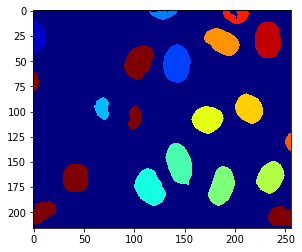

In [106]:
get_js_video(np.expand_dims(trial.y_tracked, axis=0))

In [767]:
print(trial.y_tracked.shape)

(40, 216, 256, 1)


In [781]:
print([trial.tracks[key]['parent'] for key in trial.tracks.keys()])
print([trial.tracks[key]['daughters'] for key in trial.tracks.keys()])
print([trial.tracks[key]['label'] for key in trial.tracks.keys()])
print([trial.tracks[key]['capped'] for key in trial.tracks.keys()])
print([key for key in trial.tracks.keys()])
print(trial.tracks[6]['frames'])
print(trial.tracks[8]['frames'])
print(trial.tracks[9]['frames'])

[None, None, None, None, None, None, None, None, 7, 7, None, None]
[[], [], [], [], [], [], [8, 10], [], [], [], [], []]
[1, 2, 3, 4, 5, 6, 7, 8, 7, 7, 7, 9]
[False, False, False, False, False, False, True, False, False, False, False, False]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
[20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


In [108]:
from sklearn.metrics import confusion_matrix
from IPython.display import clear_output
import time

datagen_val = SiameseDataGenerator(
    rotation_range=180,  # randomly rotate images by 0 to rotation_range degrees
    shear_range=0,  # randomly shear images in the range (radians , -shear_range to shear_range)
    horizontal_flip=0,  # randomly flip images
    vertical_flip=0)  # randomly flip images

batch_size=128
min_track_length=5
# fit the model on the batches generated by datagen.flow()
test = datagen_val.flow(train_dict, batch_size=batch_size, min_track_length=min_track_length, shuffle=False)

cm = np.zeros((3,3))
N_div = 0.
N_tot = 0.

for batch_x, batch_y in test:
    clear_output(wait=True)
    
    y_pred = tracking_model.predict(batch_x)
    
    truth = np.argmax(batch_y, axis=-1)
    pred = np.argmax(y_pred, axis=-1)
    cm_temp = confusion_matrix(truth,pred)
    if cm_temp.shape[0] == 2:
        cm[0:2,0:2] += cm_temp
    else:
        cm += confusion_matrix(truth,pred)
        
    N_div += np.sum(truth == 2)
    N_tot += truth.shape[0]
    
    print(np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2), N_div/N_tot)

    
# y_true = test.classes
# y_pred = tracking_model.predict_generator(test)
# print(y_pred)
# Y_test = np.argmax(y_test, axis=1) # Convert one-hot to index
# y_pred = model.predict_classes(x_test)
# print(classification_report(y_true, np.argmax(y_pred, axis=-1)))

[[0.98 0.01 0.01]
 [0.01 0.98 0.01]
 [0.08 0.01 0.91]] 0.33363660690393365


KeyboardInterrupt: 